In [10]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime

In [11]:
df = pd.read_csv(r'C:\Users\user\Desktop\datasets\wfp_food_prices_ken.csv', low_memory=False)

In [12]:
df.columns = df.columns.str.lower() # normalize
print("rows, cols:", df.shape)
display(df.head(6))

rows, cols: (12189, 16)


,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,1/15/2006,Coast,Mombasa,Mombasa,191,-4.05,39.67,cereals and tubers,Maize,51,KG,actual,Wholesale,KES,16.13,0.22
1,1/15/2006,Coast,Mombasa,Mombasa,191,-4.05,39.67,cereals and tubers,Maize (white),67,90 KG,actual,Wholesale,KES,1480.00,20.58
2,1/15/2006,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,17.00,0.24
3,1/15/2006,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Potatoes (Irish),148,50 KG,actual,Wholesale,KES,1249.99,17.39
4,1/15/2006,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Sorghum,65,90 KG,actual,Wholesale,KES,1800.00,25.03
5,1/15/2006,Eastern,Kitui,Kitui,187,-1.37,38.02,pulses and nuts,Beans (dry),262,KG,actual,Retail,KES,39.00,0.54


In [13]:
# show candidate columns to confirm field names

[c for c in df.columns if any(k in c for k in
                              ['date', 'price', 'commodity', 'market', 'unit', 'usd'])]

['date',
 'market',
 'market_id',
 'commodity',
 'commodity_id',
 'unit',
 'priceflag',
 'pricetype',
 'price',
 'usdprice']

In [14]:
## Light cleaning

# keep relevant columns
cols = [c for c in ['date', 'price', 'commodity', 'market'] if c in df.columns]
df = df[cols].copy()

# parse types
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop rows missing date or commodity (essentials)
df = df.dropna(subset=['date', 'commodity'])

# create month for monthly aggregation (first day of month)
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

# Trim commodity/market strings

df['commodity'] = df['commodity'].astype(str).str.strip().str.title()
if 'market' in df.columns:
    df['market'] = df['market'].astype(str).str.strip().str.title()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12189 entries, 0 to 12188
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       12189 non-null  datetime64[ns]
 1   price      12189 non-null  float64       
 2   commodity  12189 non-null  object        
 3   market     12189 non-null  object        
 4   month      12189 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 476.3+ KB


In [15]:
# normalize columns names, ensure types creates 'month' column for monthly aggregation.

In [16]:
## Conservative price imputation & national monthly aggregation

# impute missing prices conservatively and aggregate to national monthly averages

#global median fallback

global_med = df['price'].median()

# compute median at multiple granulation for conservative imputation
# (commodity, market, month) -> (commodity, month) -> commodity -> global

med_exact = df.groupby(['commodity', 'market', 'month'])['price'].median().rename('med_exact') if 'market' in df.columns else pd.Series()
med_cm = df.groupby(['commodity', 'month'])['price'].median().rename('med_cm')
med_c = df.groupby('commodity')['price'].median().rename('med_c')

In [17]:
# merge median back

df = df.merge(med_cm.reset_index(), on=['commodity', 'month'], how='left')
df = df.merge(med_c.reset_index(), on= ['commodity'], how='left')
if 'market' in df.columns:
    df = df.merge(med_exact.reset_index(), on=['commodity', 'market', 'month'], how='left')


In [18]:
# impute function

def fill_price(row):
    if pd.notnull(row['price']):
        return row['price']
    if 'market' in df.columns and pd.notnull(row.get('med_exact')):
        return row['med_exact']
    if pd.notnull(row.get('med_cm')):
        return row['med_cm']
    if pd.notnull(row.get('med_c')):
        return row['med_c']
        
df['price_filled'] = df.apply(fill_price, axis=1)

In [19]:
# aggregate to national monthly average per commodity

national = df.groupby(['commodity', 'month'], as_index=False)['price_filled'].mean().rename(columns={'price_filled':'avg_price'})
national = national.sort_values(['commodity', 'month']).reset_index(drop=True)

# save cleaned history for Power BI
national.to_csv("national_monthly_clean_csv", index=False)

display(national.head(8))

,commodity,month,avg_price
0,Bananas,2020-08-01,8.000000
1,Bananas,2021-01-01,13.228750
2,Bananas,2021-02-01,13.496667
3,Bananas,2021-03-01,11.663500
4,Bananas,2021-04-01,12.950833
5,Bananas,2021-05-01,11.979000
6,Bananas,2021-06-01,12.300000
7,Bananas,2021-07-01,13.000000


In [20]:
## imputes missing prices using progressively broader median to avoid throwing away many rows.
## Then computes the national monthly average per commodity (avg_price). This national table answers trend/inflation and is Power BI ready.

,commodity,mean_yoy_pct
15,"Milk (Camel, Fresh)",136.508325
19,Onions (Dry),52.815392
3,Beans (Rosecoco),44.243878
6,Cooking Fat,33.075756
2,Beans (Dry),20.628560
14,Meat (Goat),20.189348
4,Beans (Yellow),19.146544
28,Sugar,17.972979
29,Tomatoes,17.502767
20,Potatoes (Irish),16.822649


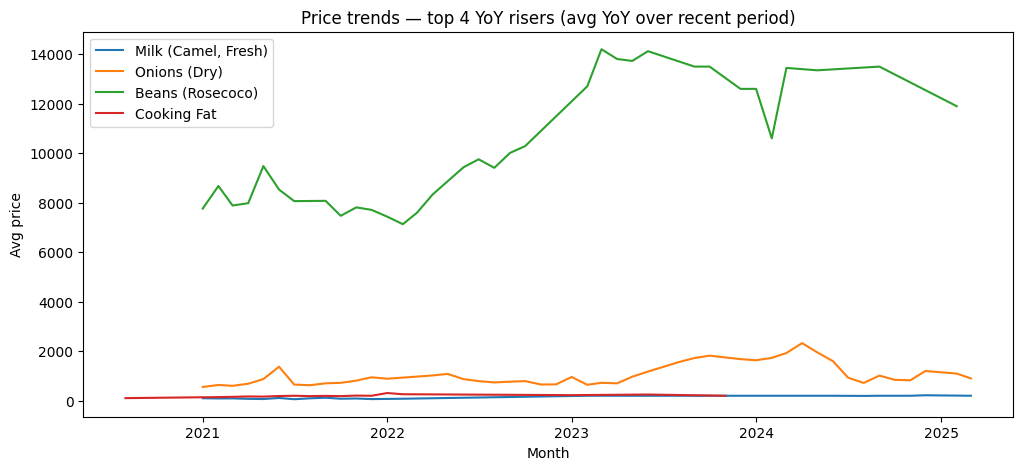

In [21]:
## Trends & Inflation Pressure (who is rising fastest; YoY)

# Cell E — Trend & YoY
# compute YoY and average annual growth rate per commodity
national['yoy_pct'] = national.groupby('commodity')['avg_price'].pct_change(12) * 100

# compute mean YoY over last 12 months per commodity (robust indicator)
latest_month = national['month'].max()
recent_12 = national[national['month'] > (latest_month - pd.DateOffset(months=24))]  # last 2 yrs

mean_annual_growth = recent_12.groupby('commodity')['yoy_pct'].mean().reset_index().rename(columns={'yoy_pct':'mean_yoy_pct'})
mean_annual_growth = mean_annual_growth.sort_values('mean_yoy_pct', ascending=False)

# Top 10 fastest rising commodities
top_risers = mean_annual_growth.head(10)
display(top_risers)

# Plot top 4 risers' historical series
top4 = top_risers['commodity'].head(4).tolist()
plt.figure(figsize=(12,5))
for c in top4:
    s = national[national['commodity']==c].set_index('month')['avg_price']
    plt.plot(s.index, s.values, label=c)
plt.title("Price trends — top 4 YoY risers (avg YoY over recent period)")
plt.xlabel("Month"); plt.ylabel("Avg price")
plt.legend(); plt.show()

# Save YoY table
mean_annual_growth.to_csv("commodity_mean_annual_yoy.csv", index=False)

In [22]:
## Explanation & how to answer the questions:

# 1.) top_risers gives the commodities with fastest rising prices (use this in your Medium/CV statements).

# 2.) yoy_pct is the YoY percent change; you can quote values for specific commodities, e.g., “Maize YoY = X% in latest month.”

In [23]:
# Cell F — volatility (coefficient of variation on monthly returns) and stability

# Use monthly returns (pct_change) to capture month-to-month volatility
returns = national.copy()
returns['month_ret'] = returns.groupby('commodity')['avg_price'].pct_change()

vol = returns.groupby('commodity')['month_ret'].agg(['std','mean']).reset_index()
vol['volatility_index'] = (vol['std'] / vol['mean'].abs()).replace([np.inf, -np.inf], np.nan).fillna(0)
vol = vol.sort_values('volatility_index', ascending=False)

# stable commodities are those with low volatility_index
stable = vol.tail(10)
volatile = vol.head(10)

display(volatile[['commodity','volatility_index']].head(10))
display(stable[['commodity','volatility_index']].head(10))

# Save
vol.to_csv("commodity_volatility_index.csv", index=False)

,commodity,volatility_index
16,Fuel (Petrol-Gasoline),326.035153
11,Cowpea Leaves,155.572938
14,Fuel (Diesel),109.001672
41,Sorghum (Red),74.200983
21,Maize Flour,48.843927
15,Fuel (Kerosene),17.199886
39,Salt,13.167728
1,Beans,12.409099
40,Sorghum,11.114984
36,Rice,9.993797


,commodity,volatility_index
25,"Milk (Camel, Fresh)",4.949829
29,Millet (Finger),4.826540
5,Beans (Mung),4.787432
28,Milk (Uht),4.629839
10,Cooking Fat,3.454037
4,Beans (Kidney),2.437886
38,"Rice (Imported, Pakistan)",2.147742
43,Spinach,1.961640
26,"Milk (Cow, Fresh)",1.379149
32,Onions (Red),0.000000


In [24]:
## Explanation & how to answer:

# 1.) volatile shows the riskiest commodities (high index → unpredictable prices). Use this to advise where to target stabilization.

# 2.) stable shows candidates for long-term safety-net focus.

In [25]:
# Cell G — seasonality: monthly average pattern + one commodity STL

# 1) Monthly seasonal pattern across years (heatmap-ready)
seasonal = national.copy()
seasonal['month_num'] = seasonal['month'].dt.month
monthly_pattern = seasonal.groupby(['commodity','month_num'])['avg_price'].mean().reset_index()
monthly_pattern.to_csv("monthly_pattern_by_commodity.csv", index=False)

# 2) STL decomposition example for a commodity with enough history
example = top4[0]  # from earlier
ts = national[national['commodity']==example].set_index('month')['avg_price'].asfreq('MS')
if ts.dropna().shape[0] >= 36:
    stl = STL(ts.interpolate().ffill().bfill(), period=12, robust=True)
    res = stl.fit()
    fig = res.plot()
    fig.set_size_inches(12,6)
    plt.suptitle(f"STL decomposition — {example}")
    plt.show()
else:
    print(f"Not enough monthly history for STL on {example} (need ~36 months).")

Not enough monthly history for STL on Milk (Camel, Fresh) (need ~36 months).


In [26]:
## Explanation & how to answer:

# 1.) Use monthly_pattern_by_commodity.csv to create a heatmap in Power BI (month vs commodity) and visually show months with recurring price spikes.

# 2.) STL decomposition separates trend/seasonality/residual — look at seasonal component to say “yes, peaks occur in months X–Y”.

In [27]:
# Cell H — SARIMAX forecast for a chosen commodity, and Jan 2026 prediction

from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarimax_forecast(commodity_name, horizon_months=12, order=(1,1,1), seasonal_order=(0,1,1,12)):
    s = national[national['commodity']==commodity_name].set_index('month')['avg_price'].asfreq('MS')
    s = s.interpolate().ffill().bfill()
    
    # fit model on full history
    model = SARIMAX(s, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    fc = res.get_forecast(steps=horizon_months)
    fc_mean = fc.predicted_mean
    fc_ci = fc.conf_int()
    return s, res, fc_mean, fc_ci

commodity_to_forecast = "Maize"  # change as needed
s, res, fc_mean, fc_ci = sarimax_forecast(commodity_to_forecast, horizon_months=18)  # 18 to include Jan 2026 if needed

# determine the predicted value for January 2026
target_date = pd.Timestamp("2026-01-01")
if target_date in fc_mean.index:
    jan2026_pred = float(fc_mean.loc[target_date])
    jan2026_ci_lower = float(fc_ci.loc[target_date].iloc[0])
    jan2026_ci_upper = float(fc_ci.loc[target_date].iloc[1])
    print(f"{commodity_to_forecast} prediction for Jan 2026: {jan2026_pred:.2f} (CI: {jan2026_ci_lower:.2f} - {jan2026_ci_upper:.2f})")
else:
    print("Model horizon does not reach Jan 2026 — increase `horizon_months` or forecast date.")

# Save forecast table (next 12 months from last historical month)
fc_out = pd.DataFrame({'month': fc_mean.index, 'forecast_price': fc_mean.values})
fc_out = pd.concat([fc_out, fc_ci.reset_index(drop=True)], axis=1)
fc_out['commodity'] = commodity_to_forecast
fc_out.to_csv(f"forecast_sarimax_{commodity_to_forecast.replace(' ','_')}.csv", index=False)

Maize prediction for Jan 2026: 67.69 (CI: 44.20 - 91.17)


In [24]:
# Explanation & how to answer:

# 1.) This fits a SARIMAX baseline on full history and forecasts forward.

# 2.) The code prints January 2026 estimate for the commodity. Increase horizon_months if dataset ends before Jan 2025.

# 3.) Confidence intervals give best-case (lower bound) and worst-case (upper bound).